# Logistic Regression - multiclass classification

## Read the data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        4560 non-null   object
 1   label       4560 non-null   int64 
 2   label_name  4560 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.0+ KB


,text,label,label_name
0,The Organization of the Petroleum Exporting Co...,0,Business
1,American business tycoon Malcolm Glazer has in...,2,Sports
2,NEW YORK (Reuters) - International Business Ma...,1,SciTech
3,"Unilever, the world #39;s largest maker of foo...",0,Business
4,Australia #39;s Nathan Baggaley was over the m...,2,Sports


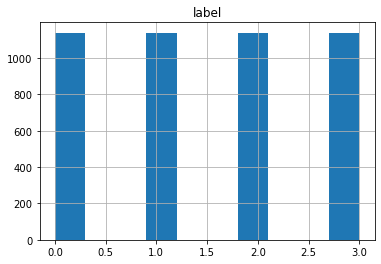

In [1]:
import pandas as pd

df_train = pd.read_json("../data/news_train.json", orient="records")
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,The first hearing in the re-trial of former le...,3,World
1,Intel #39;s board has given the go ahead for t...,0,Business
2,Stocks closed higher on Wall Street as investo...,0,Business
3,Even with a boost from higher oil prices and g...,0,Business
4,Vornado Realty Trust said on Friday it has acq...,0,Business


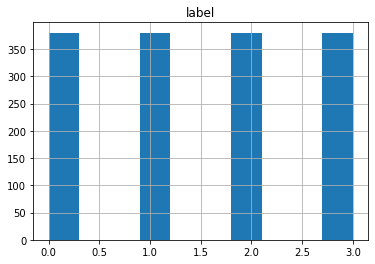

In [2]:
df_val = pd.read_json("../data/news_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,While rivals scramble to catch up on the deskt...,1,SciTech
1,AP - UCLA soccer coach Jillian Ellis was happy...,2,Sports
2,PCI Express allows Nvidia to tap into system m...,1,SciTech
3,AP - The Federal Election Commission on Thursd...,3,World
4,City officials hope there are people willing t...,1,SciTech


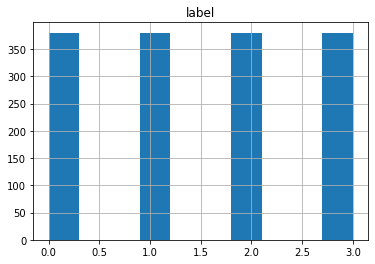

In [3]:
df_test = pd.read_json("../data/news_test.json", orient="records")
df_test.info()
df_test.hist()
df_test.head()

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

STOPWORDS = stopwords.words("english")

def is_html_tag(word):
    w = word.replace("\n", "")
    return w.startswith("<") or w.startswith(">") or w.startswith("/") or w.strip()[:2] == "br"

def remove_html_tags(sentence):
    single_spaces = " ".join(sentence.split())

    return " ".join([token for token in single_spaces.split(" ") if not is_html_tag(token)])

def tokenize_sentence(sentence):
    return word_tokenize(sentence.lower())

def remove_stopwords(sentence):
    return " ".join([word for word in sentence.split(" ") if not word in STOPWORDS])

def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word.isalpha()]

def preprocess(sentence):
    return remove_punctuation(tokenize_sentence(remove_stopwords(remove_html_tags(str(sentence)))))

print(preprocess(df_train["text"].values[1]))


['american', 'business', 'tycoon', 'malcolm', 'glazer', 'increased', 'stake', 'manchester', 'united', 'buying', 'another', 'worth', 'shares', 'club']


In [5]:
df_train["text"] = df_train["text"].apply(preprocess)
df_train.head()

,text,label,label_name
0,"[the, organization, petroleum, exporting, coun...",0,Business
1,"[american, business, tycoon, malcolm, glazer, ...",2,Sports
2,"[new, york, reuters, international, business, ...",1,SciTech
3,"[unilever, world, s, largest, maker, food, soa...",0,Business
4,"[australia, s, nathan, baggaley, moon, winning...",2,Sports


In [6]:
def build_vocab(tokenized_input, vocab_size):
    d = dict()

    for tokens in tokenized_input:
        for token in tokens:
            # double check
            if token not in STOPWORDS and token.isalpha():
                d[token] = d.get(token, 0) + 1

    del d["br"]

    return {k for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:vocab_size]}

In [7]:
VOCAB_SIZE = 10000
VOCAB = build_vocab(df_train["text"].values, VOCAB_SIZE) # (!) Always build the vocabulary on the TRAIN dataset

In [8]:
len(VOCAB)

10000

In [9]:
LABELS = df_train["label"].unique()
LABELS

array([0, 2, 1, 3], dtype=int64)

In [10]:
LABELS_TO_NAMES = {label: df_train[df_train["label"] == label].iloc[0]["label_name"] for label in LABELS}
LABELS_TO_NAMES

{0: 'Business', 2: 'Sports', 1: 'SciTech', 3: 'World'}

In [11]:
def get_frequencies_for_labels(df):
    dict_freqs = {label: {} for label in LABELS}

    for idx in range(df.shape[0]):
        tokens = df.iloc[idx, 0]
        label = df.iloc[idx, 1]
        
        for token in set(tokens):
            if token in VOCAB:
                dict_freqs[label][token] = dict_freqs[label].get(token, 0) + 1
            

    return dict_freqs

In [12]:
frequency_table = get_frequencies_for_labels(df_train)

In [13]:
frequency_table[0]["money"]

9

In [14]:
frequency_table[1]["money"]

5

In [15]:
import numpy as np

def extract_features(frequency_table, tweet_tokens):
    label_frequencies = {label: 0 for label in LABELS}

    for t in tweet_tokens:
        for label in LABELS:
            label_frequencies[label] += frequency_table[label].get(t, 0)
    
    return pd.Series(label_frequencies)


In [16]:
X_train_logistic = df_train["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_train_logistic

,0,2,1,3
0,543,179,190,191
1,229,233,99,136
2,1269,786,849,934
3,433,128,204,79
4,171,538,138,186
...,...,...,...,...
4555,76,12,19,9
4556,700,416,319,714
4557,154,797,168,268
4558,308,169,179,214


In [17]:
y_train_logistic = df_train["label"].values
y_train_logistic

array([0, 2, 1, ..., 2, 0, 3], dtype=int64)

In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=200).fit(X_train_logistic, y_train_logistic)

In [19]:
from sklearn.metrics import accuracy_score

preds_train = clf.predict(X_train_logistic)

print("Train accuracy:", accuracy_score(y_train_logistic, preds_train))

Train accuracy: 0.8232456140350877


## Validation

In [20]:
X_val = df_val["text"].apply(preprocess)
X_val_logistic = df_val["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
y_val_logistic = df_val["label"].values
X_val_logistic

,0,2,1,3
0,72,61,32,30
1,74,66,57,30
2,48,48,38,21
3,51,41,66,23
4,42,34,32,16
...,...,...,...,...
1515,74,56,28,29
1516,56,42,27,19
1517,59,39,67,13
1518,49,33,42,13


In [21]:
preds_val = clf.predict(X_val_logistic)

print("Validation accuracy:", accuracy_score(y_val_logistic, preds_val))

Validation accuracy: 0.24802631578947368


## Test

In [22]:
X_test = df_test["text"].apply(preprocess)
X_test_logistic = df_test["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
y_test_logistic = df_test["label"].values
X_test_logistic

,0,2,1,3
0,46,50,63,15
1,57,58,72,26
2,44,43,78,19
3,58,58,51,28
4,78,74,78,34
...,...,...,...,...
1515,90,58,139,27
1516,79,56,55,25
1517,76,59,93,26
1518,38,27,30,24


In [23]:
preds_test = clf.predict(X_test_logistic)

print("Test accuracy:", accuracy_score(y_test_logistic, preds_test))

Test accuracy: 0.25
